#  Прогнозирование заказов такси

Нужно построить модель для предсказания количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import  LinearRegression
from catboost import  CatBoostRegressor

from sklearn.metrics import mean_squared_error

In [66]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [68]:
data['datetime'] = pd.to_datetime(data['datetime'],format='%Y-%m-%d %H:%M:%S')

In [69]:
data = data.set_index('datetime')
data = data.sort_index(ascending=True)

In [70]:
data.index.is_monotonic

True

In [71]:
data = data.resample('1H').sum()

In [72]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

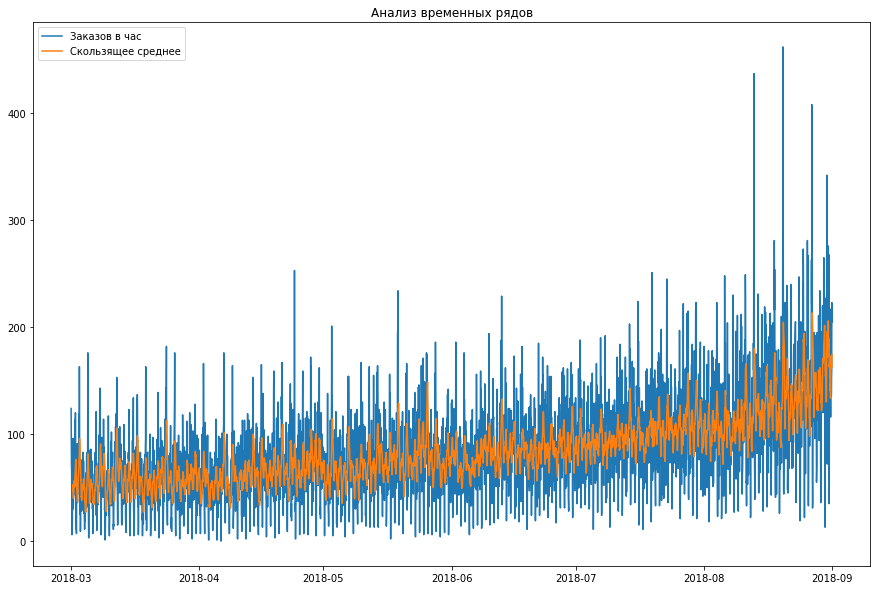

In [73]:
plt.figure(figsize=(15, 10))
plt.plot(data)
plt.plot(data.rolling(10).mean())
plt.title("Анализ временных рядов")
plt.legend(['Заказов в час','Скользящее среднее'])
plt.show()

In [74]:
decomposed = seasonal_decompose(data)

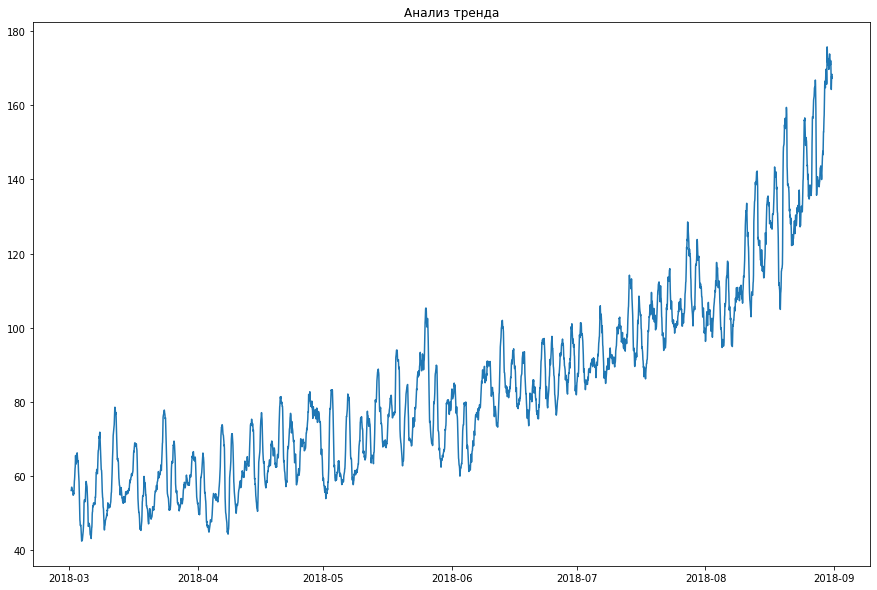

In [75]:
plt.figure(figsize=(15, 10))
plt.plot(decomposed.trend)
plt.title("Анализ тренда")
plt.show()

<Figure size 1080x720 with 0 Axes>

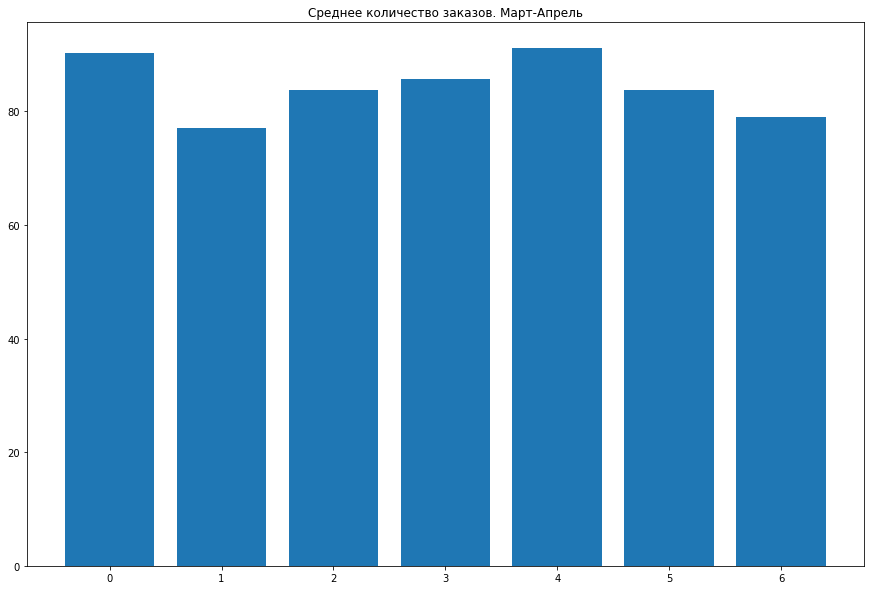

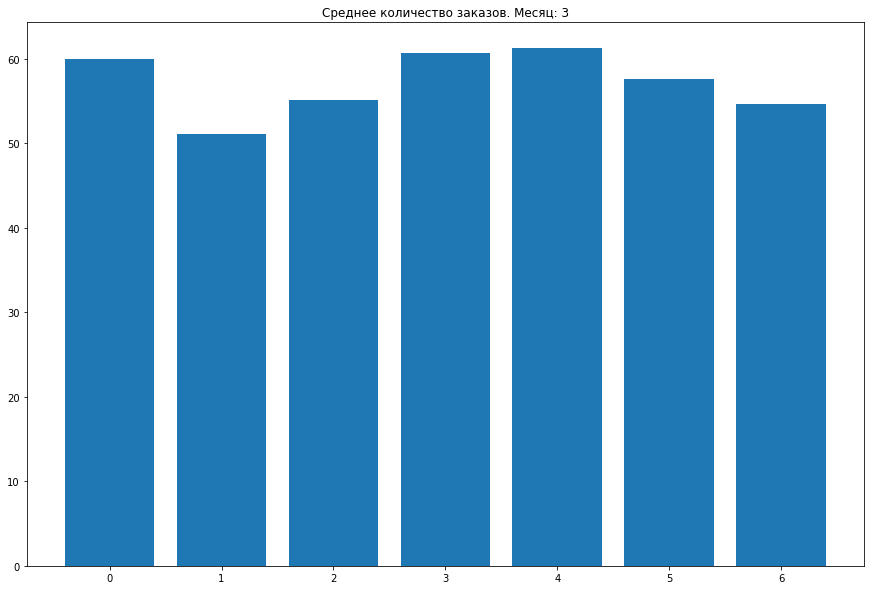

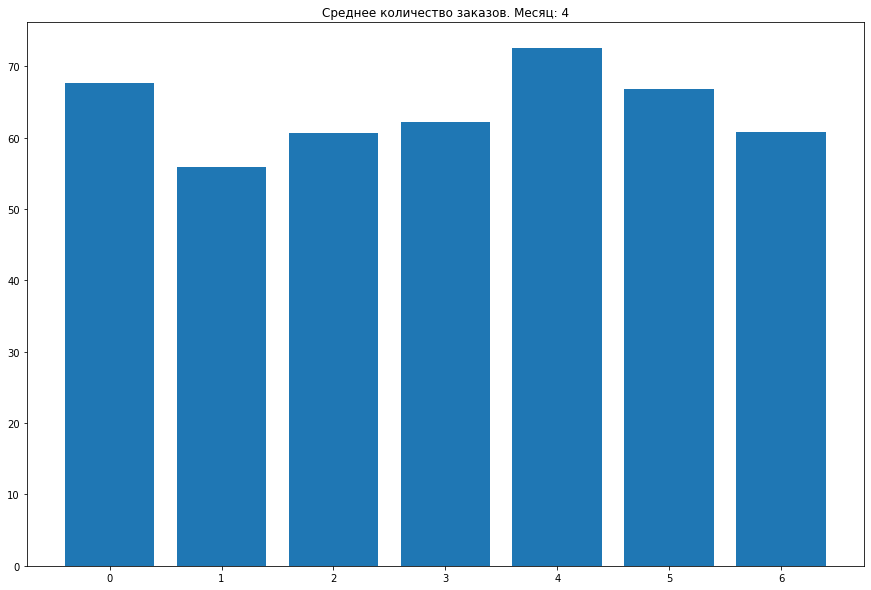

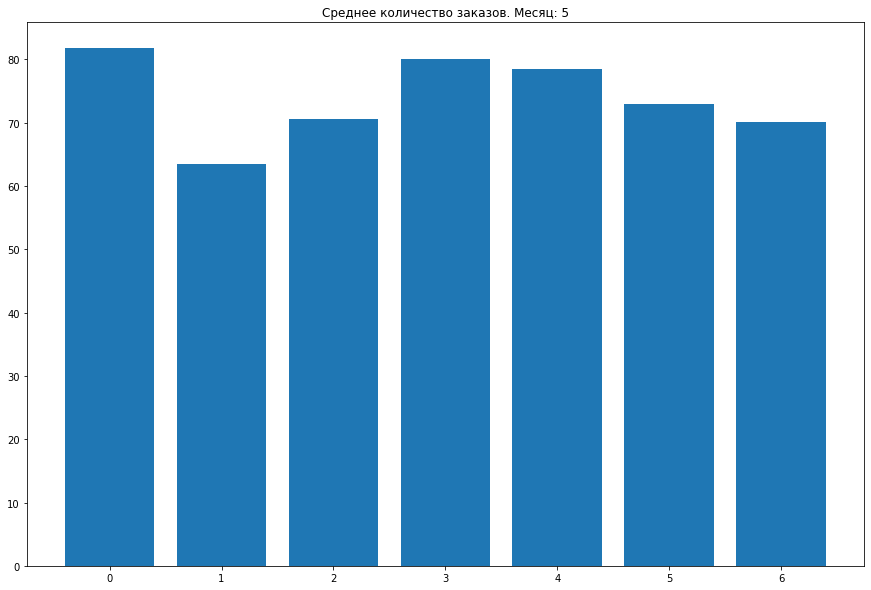

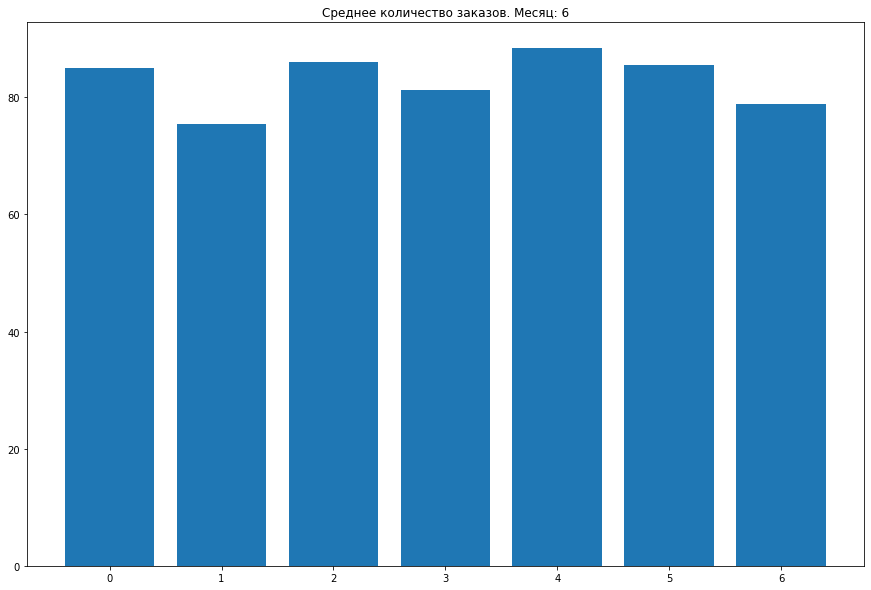

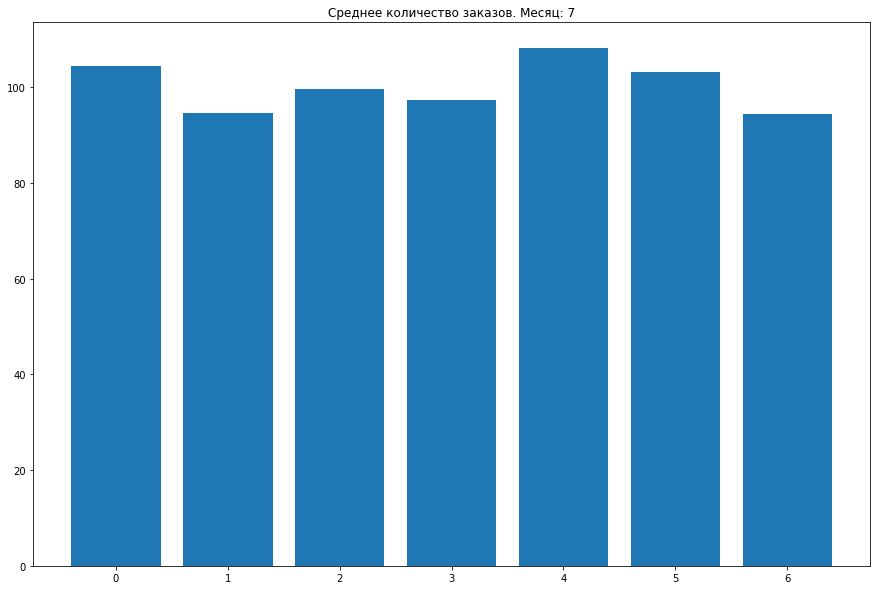

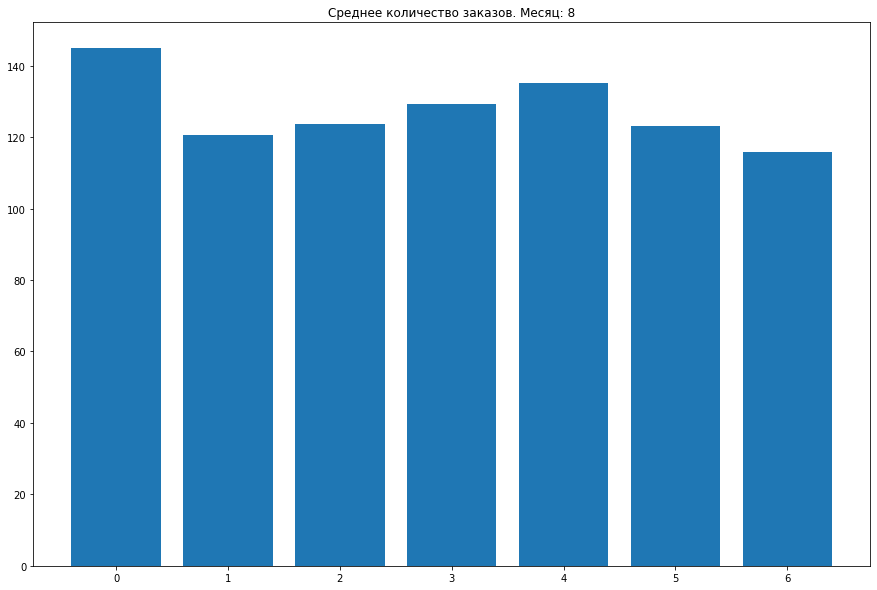

In [76]:
plt.figure(figsize=(15, 10))
dow_stat = []
for dow in data.index.dayofweek.unique().sort_values():
    dow_stat.append(data[data.index.dayofweek==dow]['num_orders'].mean())
plt.figure(figsize=(15, 10))
plt.bar(data.index.dayofweek.unique().sort_values(), dow_stat)
plt.title("Среднее количество заказов. Март-Апрель")
plt.show();
for month in data.index.month.unique().sort_values():
    dow_stat = []
    for dow in data.index.dayofweek.unique().sort_values():
        dow_stat.append(data[(data.index.dayofweek==dow)&(data.index.month==month)]['num_orders'].mean())
    plt.figure(figsize=(15, 10))
    plt.bar(data.index.dayofweek.unique().sort_values(), dow_stat)
    plt.title("Среднее количество заказов. Месяц: {}".format(month))
    plt.show();

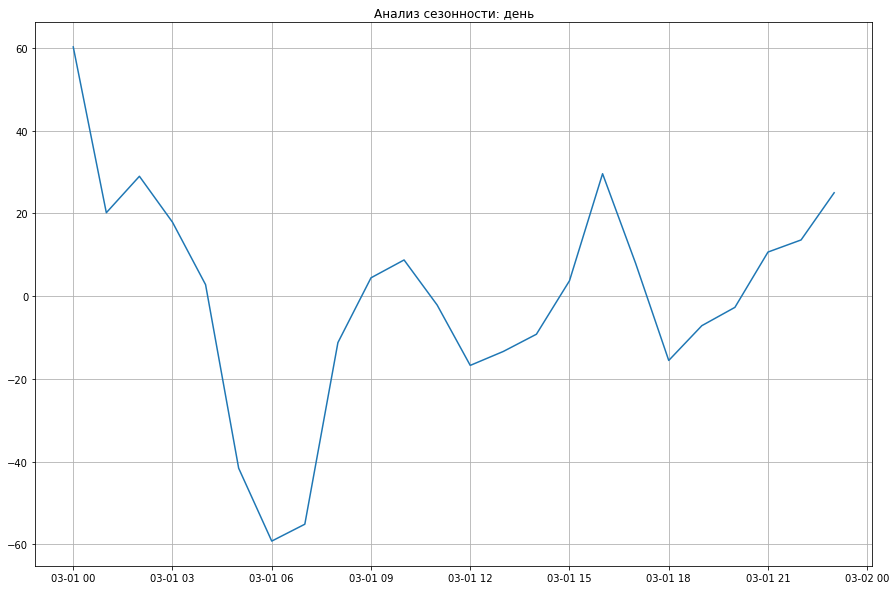

In [77]:
plt.figure(figsize=(15, 10))
plt.plot(decomposed.seasonal[0:24])
plt.grid(True)
plt.title("Анализ сезонности: день")
plt.show()

In [78]:
decomposed_d = seasonal_decompose(data.resample('1d').sum())

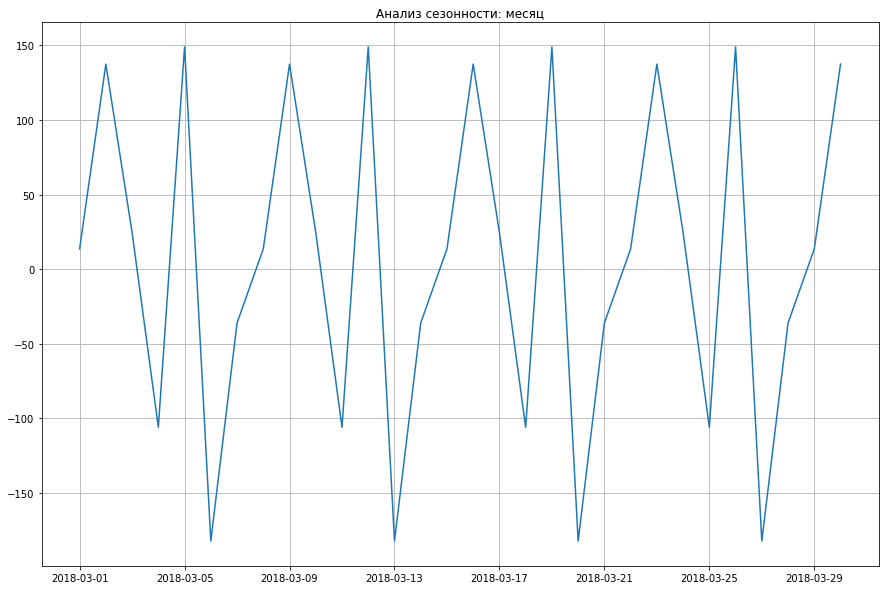

In [79]:
plt.figure(figsize=(15, 10))
plt.plot(decomposed_d.seasonal[0:30])
plt.grid(True)
plt.title("Анализ сезонности: месяц")
plt.show()

In [80]:
data['2018-03-05'].index.dayofweek[0]

/tmp/ipykernel_48/1045099484.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data['2018-03-05'].index.dayofweek[0]


0

In [81]:
data['2018-03-09'].index.dayofweek[0]

/tmp/ipykernel_48/3343467835.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data['2018-03-09'].index.dayofweek[0]


4

Количество заказов возрастает к концу лета

Такси наименее востребовано по вторникам, лишь в августе средний показатель заказов в этот день выше, чем в воскресенье

Больше всего заказов в 00 часов, в 06 - минимум.

Понедельник и пятница имеют наибольший показатель сезонности. Вторник и воскресенье - наименьший

## Обучение

In [84]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['dayofweek'] = data['dayofweek'].astype('str')
    data['hour'] = data['hour'].astype('str')

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [85]:
make_features(data, 9, 2)

In [86]:
data = pd.get_dummies(data, drop_first=True)

In [87]:
data = data.dropna()
train, test = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)
features_train = train.drop(['num_orders'], axis=1)
features_valid = valid.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']
features_train.shape , features_test.shape, features_valid.shape, target_train.shape, target_valid.shape, target_test.shape

((3525, 39), (441, 39), (441, 39), (441,), (3525,), (441,))

**DecisionTreeRegressor**

In [102]:
model_dtr = None
best_res =1000

for depth in range(1,20,3):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train,target_train)
    res = mean_squared_error(target_valid, model.predict(features_valid), squared=False)
    if res < best_res:
        best_res = res
        model_dtr=model
print('RMSE на валидационной выборке:', best_res)

RMSE на валидационной выборке: 38.626571208412486


**LinearRegression**

In [103]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train);
print('RMSE на валидационной выборке:', mean_squared_error(target_valid, model.predict(features_valid), squared=False))

RMSE на валидационной выборке: 48.66481803912207


**CatBoostRegressor**

In [104]:
model_cb = None
best_res =1000
for depth in range(1,16,4):
    for rate in np.arange(0.1,0.9,0.3):
        model = CatBoostRegressor(iterations=50, depth=depth, learning_rate=rate, loss_function='RMSE')
        model.fit(features_train, target_train, verbose=False, early_stopping_rounds=4);
        res = mean_squared_error(target_valid, model.predict(features_valid), squared=False)
        if res < best_res:
            best_res = res
            model_cb=model
print('RMSE на валидационной выборке:', best_res)

RMSE на валидационной выборке: 33.208782402981626


## Тестирование

In [105]:
mean_squared_error(target_test, model_dtr.predict(features_test), squared=False)

58.96104850322475

In [106]:
mean_squared_error(target_test, model_lr.predict(features_test), squared=False)

45.537386013422186

In [107]:
mean_squared_error(target_test, model_cb.predict(features_test), squared=False)

52.82459746323097

Вывод:

Количество заказов возрастает к концу лета

Такси наименее востребовано по вторникам, лишь в августе средний показатель заказов в этот день выше, чем в воскресенье

Больше всего заказов в 00 часов, в 06 - минимум.

Понедельник и пятница имеют наибольший показатель сезонности. Вторник и воскресенье - наименьший

Предсказания линейной регрессии показали худший результат на валидационной выборке, но на тестовой только линейная регрессия имеет допустимую матрику RMSE